In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

import warnings
warnings.filterwarnings(action='ignore')

## 2nd Attention

Считаем, что в каждый момент времени набор временных рядов задается матрицей $\textbf{X} \in R^{n \times L}$:

$$
\begin{equation}
\textbf{X} = \left( \begin{array}{cccc}
x^{(1)}_{t - \text{L} + 1} & x^{(1)}_{t - \text{L} + 2} & \ldots & x^{(1)}_{t} \\
x^{(2)}_{t - \text{L} + 1} & x^{(2)}_{t - \text{L} + 2} & \ldots & x^{(2)}_{t} \\
\ldots & \ldots & \ldots & \ldots \\
x^{(n)}_{t - \text{L} + 1} & x^{(n)}_{t - \text{L} + 2} & \ldots & x^{(n)}_{t}.
\end{array}\right)
\end{equation}
$$

$i$-й столбец матрицы $\textbf{X}$ обозначим через вектор $\textbf{y}^{i}$. А $i$-ю строку матрицы $\textbf{X}$ обозначим через вектор $\textbf{x}^{(i)}$.   В каждый момент времени поставим в соответствие данному набору матрицу $\Sigma_t \in R^{\text{n} \times \text{n}}$, элементы которой описывают взаимосвязь различных компонент набора временных рядов. Рассмотрим три способа построения данной матрицы.

#### Способ № 1

$$
\begin{equation}
\Sigma_t^{1} = \dfrac{1}{L}\sum\limits_{i = 1}^{L} \textbf{y}^{i} \textbf{y}^{iT}
\end{equation}
$$

#### Способ № 2

Введем вектор $\mathbf{m} \in R^{\text{n}}$ следующим образом:

$$
\begin{equation}
\mathbf{m}_j = \dfrac1L \sum\limits_{i = 1}^{L} \textbf{y}^{i}_j.
\end{equation}
$$

А теперь матрицу $\Sigma_t^{2}$, при построении которой, в отличие от $\Sigma_t^{1}$, процентрируем векторы $\textbf{y}^{i}$ с помощью  $\textbf{m}$:

$$
\begin{equation}
\Sigma_t^{2} = \dfrac{1}{L}\sum\limits_{i = 1}^{L} (\textbf{y}^{i} - \textbf{m}) (\textbf{y}^{i} - \textbf{m})^T
\end{equation}
$$

#### Способ № 3

Для каждой строки $\textbf{x}^{(j)}$, $j \in {1, \ldots, n}$ матрицы $\textbf{X}$ введем величину:

$$
\begin{equation}
\sigma_j = \sqrt{\dfrac{1}{L} \sum\limits_{i = 1}^L (\textbf{x}^{(j)}_i - \textbf{m}_i)^2}.
\end{equation}
$$

Теперь введем матрицу $\Sigma_t^3$ следующим образом:

$$
\begin{equation}
(\Sigma_t^{3})_{ij} = \dfrac{(\Sigma_t^{2})_{ij}}{\sigma_i \sigma_j}.
\end{equation}
$$

# `Функции преобразования временных рядов в временные ряды их корреляций.`

In [221]:
def corr_matrix(ts, L, option=3, actual_forecast=False):

    '''
        Данная функция принимает на вход набор временных рядов, ширину окна и возвращает массив X.
        X[i] - матрица корреляции компонент временного ряда в момент времени i + L + 1
    '''

    X = []

    if actual_forecast:
      L1 = L + 1
    else:
      L1 = L

    ts_size = ts.shape[0] # Длина временных рядов
    ts_components = ts.shape[1] # Количество компонент вр.р. в наборе

    for i in range(ts_size - L + 1): # По каждым последовательным L отсчетам времени строим матрицу Сигма
        sigma = np.zeros((ts_components, ts_components)) # Инициализируем нулями
        m = np.zeros((ts_components, 1)) # Вектор матожидания тоже инициализируем нулями

        if option == 2 or option == 3:
            for k in range(ts_components): # Вычисляем вектор матожидания
                sum_ = 0
                for l in range(L):
                    sum_ += ts.iloc[i + l, k] / L
                m[k, 0] = sum_

        if option == 3:
            sqrt_dispercion = [] # Заводим массив, где будут храниться корни из дисперсии для каждого момента времени из [i, i + L - 1]
            for k in range(ts_components): # Рассчитываем вектор корней из дисперсии
                sum_ = 0
                for time in range(L):
                    sum_ += ((ts.iloc[i + time, k] - m[k, 0]) ** 2) / L

                sqrt_dispercion.append(np.sqrt(sum_))

        for j in range(L): # Считаем матрицу Sigma_2
            vector = ts.iloc[i + j, :ts_components].values
            vector = vector.reshape(-1, 1)
            sigma += np.outer(vector - m, (vector - m).T) / L1

        if option == 3:
            for row in range(ts_components): # Делим [row, col] - ый элемент матрицы на соответствующие корни из дисперсии, получаем матрицу корреляции, т.е Sigma_3
                for col in range(ts_components):
                    sigma[row, col] = sigma[row, col] / (sqrt_dispercion[row] * sqrt_dispercion[col])

        X.append(sigma) # Добавляем полученную матрицу в массив входов

    return X

In [222]:
def corr_mtx_to_ts(X, L, num_of_series, option=0):

    '''
        Данная функция получает на вход массив матриц корреляции X
        (X[i] - матрица корреляции компонент временного ряда в момент времени i + L + 1) и ширину окна L.
        Далее массив преобразуется в набор временных рядов, состоящий из n(n - 1) / 2 компонент,
        где каждая компонента - это изменение корреляции между временными рядами исходного набора.
    '''

    corr_data = []
    X_size = len(X)
    for i in range(X_size):
        upper_triangle_indices = np.triu_indices(X[i].shape[0], k=option)
        upper_triangle_elements = X[i][upper_triangle_indices]
        corr_data.append(upper_triangle_elements)
    column_names = []

    for i in range(1, num_of_series + 1):
        for j in range(i + option, num_of_series + 1):
            column_names.append(f'corr({i}, {j})')

    time = np.arange(L - 1, X_size + L - 1)
    corr_ts = pd.DataFrame(corr_data, index=time, columns=column_names)
    return corr_ts

# `Функции обратного преобразования временных рядов из корреляций в матрицы.`

In [223]:
def get_sym_matrix(upper_triangular_elements, option=0):
  idx = 0
  n = int((-1 + np.sqrt(1 + 8 * len(upper_triangular_elements))) / 2) + option
  symm_matrix = np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      if i > j:
        symm_matrix[i, j] =  symm_matrix[j, i]
      elif i == j and option == 1:
        symm_matrix[i, j] = 1
      else:
        symm_matrix[i, j] = upper_triangular_elements[idx]
        idx += 1

  return symm_matrix

def get_corr_matrices(corr_ts, option=0):
  forecast_size = corr_ts.shape[0]
  components_size = corr_ts.shape[1]
  matrix_ts = []
  for i in range(forecast_size):
    elements = corr_ts.iloc[i, :].values
    matrix_ts.append(get_sym_matrix(elements, option=option)) # metric

  return matrix_ts

# `Реализация LSTM`

In [4]:
def scalling(ts):
    '''
        Данная функция переводит значения набора временных рядов в интервал (-1, 1).
        Возвращает отмасштабированный ряд и словарь скаллеров для дальнейшего обратного преобразования.
    '''
    scalled_ts = ts
    scalers = {}
    for i in ts.columns:
        scaler = MinMaxScaler(feature_range=(-1,1))
        s_s = scaler.fit_transform(scalled_ts[i].values.reshape(-1,1))
        s_s = np.reshape(s_s,len(s_s))
        scalers['scaler_'+ i] = scaler
        scalled_ts[i] = s_s
    return scalled_ts, scalers


def split_series(series, n_past, n_future):

    '''
        Данная функция по параметрам:
            n_past - количество прошлых значений, используемых для прогноза следующих значений,
            n_future - количество прогнозируемых значений,
        разбивает временной ряд на пары (X, y), для дальнейшего обучения модели.
        X - вход, предыдущие n_past значений набора временного ряда.
        y - выход, следующие n_future значений временного ряда.
    '''

    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
              break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)


def get_split_series(train_ts, test_ts, n_past, num_of_series, n_future=1):
    X_train, y_train = split_series(train_ts.values,n_past, n_future)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_of_series))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], num_of_series))
    X_test, y_test = split_series(test_ts.values,n_past, n_future)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], num_of_series))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], num_of_series))
    return X_train, y_train, X_test, y_test


def get_e2d2_model(n_past, num_of_series, n_future=1):
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, num_of_series))
    encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_of_series))(decoder_l2)

    model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    return model_e2d2


def train_model(model, X_train, y_train, X_test, y_test, reduce_lr, epochs=10, batch_size=32):
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
    history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),batch_size=batch_size,verbose=0,callbacks=[reduce_lr])
    forecast = model.predict(X_test)
    return forecast


def inverse_scalling(columns, scalers, ts):
    for index, i in enumerate(columns):
        scaler = scalers['scaler_'+i]
        ts[:, :, index] = scaler.inverse_transform(ts[:,:,index])
    return ts


def MAE_MSE_avg(forecast_ts, test_ts, num_of_series):
    sum_mape = 0
    sum_mse = 0
    for i in range(num_of_series):
        ytrue = test_ts.iloc[:, i].values
        yhat = forecast_ts.iloc[:, i].values
        mae = MAE(ytrue, yhat)
        mse = MSE(ytrue, yhat)
        sum_mape += mae
        sum_mse += mse
    return sum_mape / num_of_series, sum_mse / num_of_series

In [5]:
def forecast(ts, n_past, num_of_series, split_point):
    # split_point = int(ts.shape[0] * train_test_ratio)
    train_ts, test_ts = ts[1:split_point], ts[split_point:]

    train, scallers_train = scalling(train_ts)
    test, scallers_test = scalling(test_ts)

    X_train, y_train, X_test, y_test = get_split_series(train, test, n_past, num_of_series)

    model_e2d2 = get_e2d2_model(n_past, num_of_series)
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
    pred_e2d2 = train_model(model_e2d2, X_train, y_train, X_test, y_test, reduce_lr)

    pred_e2d2 = inverse_scalling(train_ts.columns, scallers_test, pred_e2d2)
    y_train = inverse_scalling(train_ts.columns, scallers_train, y_train)
    y_test = inverse_scalling(train_ts.columns, scallers_test, y_test)

    pred_e2d2 = pd.DataFrame(pred_e2d2.reshape(ts.shape[0] - split_point - n_past, num_of_series))
    y_test = pd.DataFrame(y_test.reshape(ts.shape[0] - split_point - n_past, num_of_series))

    return pred_e2d2, y_test

In [6]:
def MAPE_MSE_avg(forecast_ts, test_ts, num_of_series):
    sum_mape = 0
    sum_mse = 0
    for i in range(num_of_series):
        ytrue = test_ts.iloc[:, i].values
        yhat = forecast_ts.iloc[:, i].values
        mape = MAPE(ytrue, yhat)
        mse = MSE(ytrue, yhat)
        sum_mape += mape
        sum_mse += mse
    return sum_mape / num_of_series, sum_mse / num_of_series

# `Реальные временные ряды`

In [224]:
colnames = ['Time'] + [f'Price{i}' for i in range(24)]

df = pd.read_csv('GermanSpotPrice.csv', names=colnames, header=None)
df = df.set_index('Time')
df = df.set_index(df.index - 731582)

df = df.iloc[:2000, :]

for i in range(7, 21):
    del df[f'Price{i}']

for i in range(3):
    df = df.rename(columns={f'Price{21 + i}': f'Price{7 + i}'})

In [225]:
num_of_series = df.shape[1]
ts_len = df.shape[0] # длина каждого из временных рядов
L = 10 # количество предыдущих значений, используемых для подсчета Sigma
num_of_corr_series_12 = int(num_of_series * (num_of_series + 1) / 2)
num_of_corr_series_3 = int(num_of_series * (num_of_series - 1) / 2) # Количество временных рядов в наборе
n_past = L # Ширина окна прогноза

In [226]:
X_1 = corr_matrix(df, L, option=1) # Создаем массив матриц корреляции при трех различных подсчетах Sigma
X_2 = corr_matrix(df, L, option=2)
X_3 = corr_matrix(df, L, option=3)

In [227]:
corr_ts_1 = corr_mtx_to_ts(X_1, L, num_of_series) # Получаем соответствующие временные ряды
corr_ts_2 = corr_mtx_to_ts(X_2, L, num_of_series)
corr_ts_3 = corr_mtx_to_ts(X_3, L, num_of_series, option=1)

# `Определение оптимального горизонта прогноза для первого способа посчета Σ.`

In [228]:
series_size = corr_ts_1.shape[0]

In [ ]:
MAPE_vs_forecast_horizon = []
MSE_vs_forecast_horizon = []

for i in range(1, 21):
    MAPE_array_for_each = []
    MSE_array_for_each = []
    for j in range(5):
        split_point = series_size - i - L
        forecast_corr_1, actual_corr_1 = forecast(corr_ts_1, n_past, num_of_corr_series_12, split_point);
        MAPE_avg, MSE_avg = MAPE_MSE_avg(forecast_corr_1, actual_corr_1, num_of_corr_series_12)
        MAPE_array_for_each.append(MAPE_avg)
        MSE_array_for_each.append(MSE_avg)
    MAPE_vs_forecast_horizon.append(MAPE_array_for_each)
    MSE_vs_forecast_horizon.append(MSE_array_for_each)

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


In [ ]:
avg_MAPE_fh = [np.array(arr).mean() for arr in MAPE_vs_forecast_horizon] # усреднение точности по нескольким повторениям одного и того же прогноза
quadratic_dev_MAPE = [np.array((np.array(arr) - np.array(arr).mean()) ** 2).mean() for arr in MAPE_vs_forecast_horizon] # среднеквадратичное отклонение

avg_MSE_fh = [np.array(arr).mean() for arr in MSE_vs_forecast_horizon] # усреднение точности по нескольким повторениям одного и того же прогноза
quadratic_dev_MSE = [np.array((np.array(arr) - np.array(arr).mean()) ** 2).mean() for arr in MSE_vs_forecast_horizon] # среднеквадратичное отклонение

Text(0.5, 1.0, 'Зависимость MSE от горизонта прогноза LSTM при первом способе прогноза Sigma.')

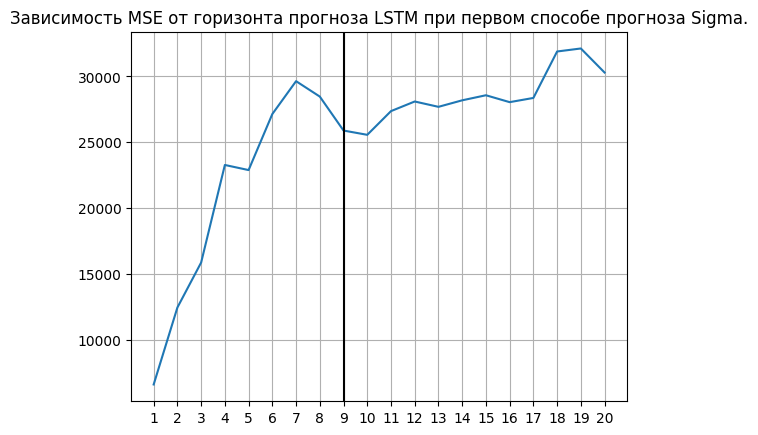

In [ ]:
plt.plot([i for i in range(1, 21)], avg_MSE_fh)
plt.grid ( True )
plt.xticks([i for i in range(1, 21)])
plt.axvline(x = 9, color='black')
plt.title("Зависимость MSE от горизонта прогноза LSTM при первом способе прогноза Sigma.")

Text(0.5, 1.0, 'Зависимость MAPE от горизонта прогноза LSTM при первом способе прогноза Sigma.')

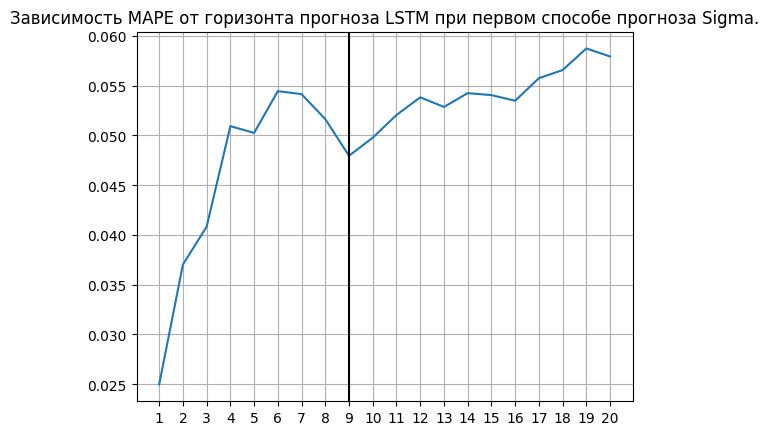

In [ ]:
plt.plot([i for i in range(1, 21)], avg_MAPE_fh)
plt.grid ( True )
plt.xticks([i for i in range(1, 21)])
plt.axvline(x = 9, color='black')
plt.title("Зависимость MAPE от горизонта прогноза LSTM при первом способе прогноза Sigma.")

`По правилу сломанной трости оптимальный горизонт прогноза равен 9.`




# Прогнозирование $\Sigma_1$ при оптимальном горизонте прогноза.

In [229]:
optimal_horizon = 9

In [230]:
split_point = series_size - optimal_horizon - L

In [231]:
forecast_corr_1, actual_corr_1 = forecast(corr_ts_1, n_past, num_of_corr_series_12, split_point)
forecast_corr_1 = forecast_corr_1.set_index(forecast_corr_1.index + split_point + 2 * L - 1)

1/1 [==============================] - 1s 1s/step


In [232]:
for i in range(num_of_corr_series_12):
    ytrue = actual_corr_1.iloc[:, i].values
    yhat = forecast_corr_1.iloc[:, i].values
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    print(f"{i}: MAPE = {mape}, MSE = {mse}")

0: MAPE = 0.02568030146160388, MSE = 10623.1369356789
1: MAPE = 0.040791740187115226, MSE = 18698.264276996808
2: MAPE = 0.03658635465759002, MSE = 10185.457461373995
3: MAPE = 0.03753068431186887, MSE = 11224.577448087777
4: MAPE = 0.04687330594253546, MSE = 12737.86800130969
5: MAPE = 0.03776390814472548, MSE = 14257.106497354627
6: MAPE = 0.059255304259641, MSE = 40756.367137123045
7: MAPE = 0.03634298732036998, MSE = 29804.700750009422
8: MAPE = 0.019267296802322965, MSE = 9073.15752773835
9: MAPE = 0.023605784630181308, MSE = 11276.088304394965
10: MAPE = 0.05650409539028388, MSE = 24467.106339068923
11: MAPE = 0.056224096270042226, MSE = 16264.708884057964
12: MAPE = 0.04820980232479131, MSE = 11418.168407733105
13: MAPE = 0.04789096606027389, MSE = 9793.21270674881
14: MAPE = 0.0372329637075656, MSE = 10295.391155599866
15: MAPE = 0.07701359754080922, MSE = 44185.83030170298
16: MAPE = 0.02068649752149119, MSE = 7620.47730521364
17: MAPE = 0.023133422056840863, MSE = 8579.956784

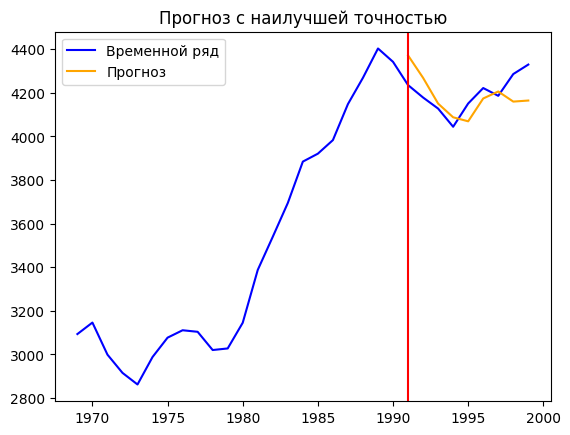

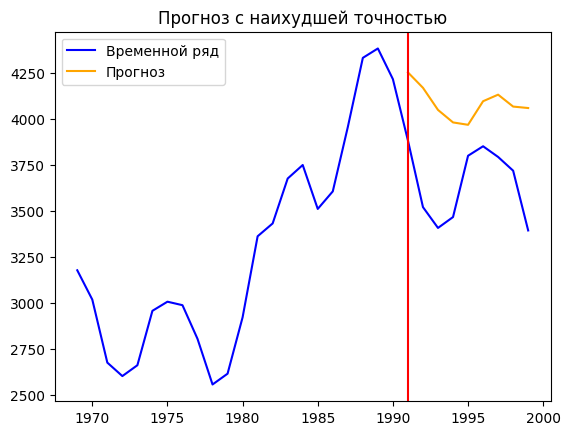

In [233]:
plt.plot(corr_ts_1.iloc[1960:, 8], label="Временной ряд", color='b')
plt.plot(forecast_corr_1.iloc[:, 8], label="Прогноз", color='orange')
plt.axvline(x = split_point + 2 * L - 1, color='r')
plt.title("Прогноз с наилучшей точностью")
plt.legend()
plt.show()

plt.plot(corr_ts_1.iloc[1960:, 47], label="Временной ряд", color='b')
plt.plot(forecast_corr_1.iloc[:, 47], label="Прогноз", color='orange')
plt.axvline(x = split_point + 2 * L - 1, color='r')
plt.title("Прогноз с наихудшей точностью")
plt.legend()
plt.show()

# `Восстановление прогноза` $\Sigma_1$

In [234]:
x = np.ones(num_of_series)

In [235]:
matrix_ts = get_corr_matrices(forecast_corr_1)

In [236]:
from scipy.optimize import Bounds, minimize

def optimized_1(x):
    sum = 0
    for i in range(L - 1):
        outer = np.outer(df.iloc[split_point + L + point + i, :].values, df.iloc[split_point + L + point + i, :].values)
        sum += outer / L
    sum += np.outer(x, x) / L
    return np.linalg.norm(sum - matrix_ts[point]) ** 2

def optimize_portfolio_1():
    bnds = Bounds(np.zeros_like(x), np.ones_like(x) * np.inf)

    res = minimize(optimized_1, x, method='SLSQP',
                   bounds=bnds)
    return res.x

In [237]:
forecasted_ = []

for point in range(optimal_horizon):
    forecasted_.append(optimize_portfolio_1())

for element in forecasted_:
    element = list(element)

forecasted_ts_x = []

for i in range(num_of_series):
    forecasted_ts_x.append([sublist[i] for sublist in forecasted_])

AVG_MAPE_x = 0
mape_list = []

for i in range(num_of_series):
    mape_ = MAPE(df.iloc[split_point + 2 * L - 1:, i].values, forecasted_ts_x[i])
    mape_list.append(mape_)
    print(f'MAPE {i} временного ряда: {mape_}')
    AVG_MAPE_x += mape_

print(f'Средняя ошибка MAPE: {AVG_MAPE_x / num_of_series}')

MAPE 0 временного ряда: 0.1663340271333692
MAPE 1 временного ряда: 0.15428020967885217
MAPE 2 временного ряда: 0.2321068563563474
MAPE 3 временного ряда: 0.29674206109873313
MAPE 4 временного ряда: 0.4580164425546309
MAPE 5 временного ряда: 0.5239692836320169
MAPE 6 временного ряда: 2.1514351718102276
MAPE 7 временного ряда: 0.11996022682382868
MAPE 8 временного ряда: 0.32442710079118336
MAPE 9 временного ряда: 0.129842978711439
Средняя ошибка MAPE: 0.4557114358590629


In [238]:
AVG_MAE_x = 0
mae_list = []
AVG_MSE_x = 0
mse_list = []

for i in range(num_of_series):
    mae_ = MAE(df.iloc[split_point + 2 * L - 1:, i].values, forecasted_ts_x[i])
    mse_ = MSE(df.iloc[split_point + 2 * L - 1:, i].values, forecasted_ts_x[i])
    mae_list.append(mae_)
    mse_list.append(mse_)
    print(f'MAE {i} временного ряда: {mae_}, MSE {i} временного ряда: {mse_}')
    AVG_MAE_x += mae_
    AVG_MSE_x += mse_

print(f'Средняя ошибка MAE: {AVG_MAE_x / num_of_series}, MSE: {AVG_MSE_x / num_of_series}')

MAE 0 временного ряда: 10.349446991061825, MSE 0 временного ряда: 169.09696255192898
MAE 1 временного ряда: 7.9664548776801825, MSE 1 временного ряда: 90.42958804952897
MAE 2 временного ряда: 9.296044643208266, MSE 2 временного ряда: 113.00162039729247
MAE 3 временного ряда: 10.739363188853199, MSE 3 временного ряда: 188.01227925392328
MAE 4 временного ряда: 13.574624526238368, MSE 4 временного ряда: 270.4601761406753
MAE 5 временного ряда: 15.322911887345633, MSE 5 временного ряда: 354.2552262880568
MAE 6 временного ряда: 34.51625343986743, MSE 6 временного ряда: 1691.9182184970227
MAE 7 временного ряда: 7.47053570533033, MSE 7 временного ряда: 104.77063466473358
MAE 8 временного ряда: 22.174070290544552, MSE 8 временного ряда: 532.5267366530587
MAE 9 временного ряда: 7.948006774509731, MSE 9 временного ряда: 82.21888761163945
Средняя ошибка MAE: 13.935771232463953, MSE: 359.66903301078605


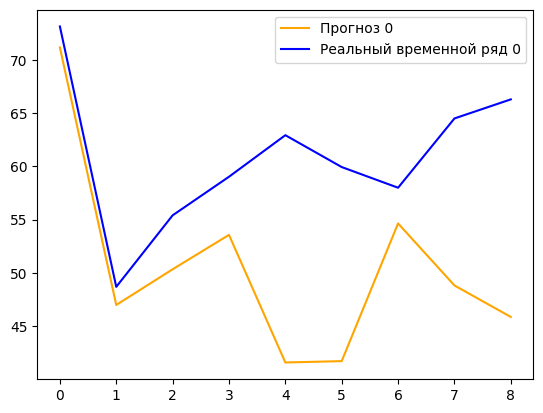

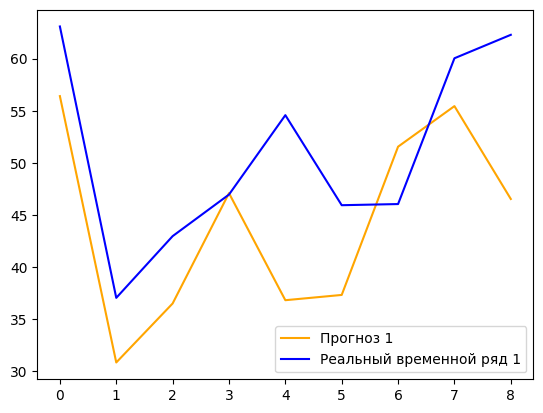

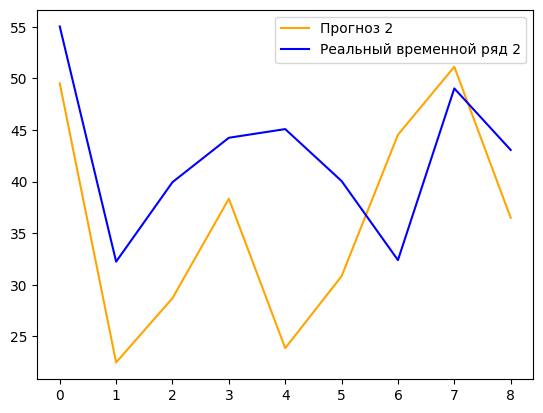

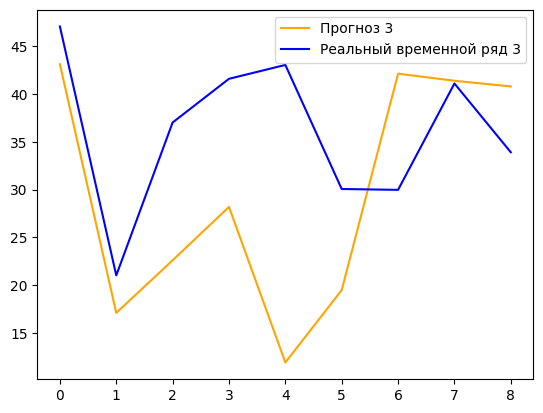

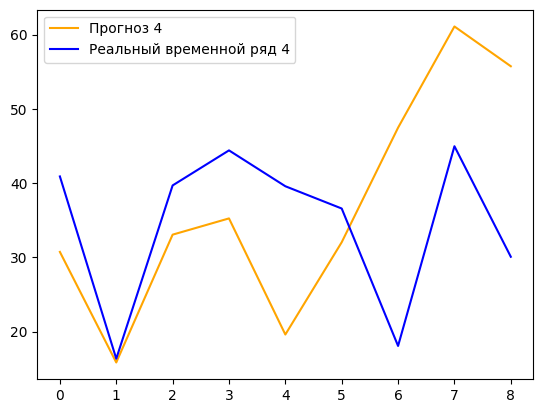

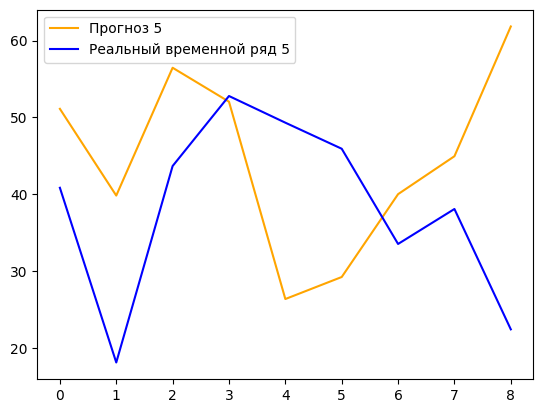

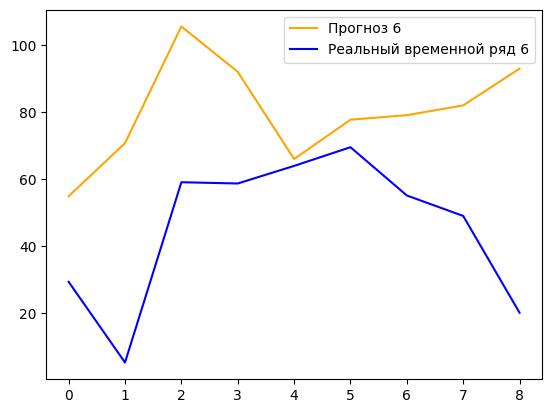

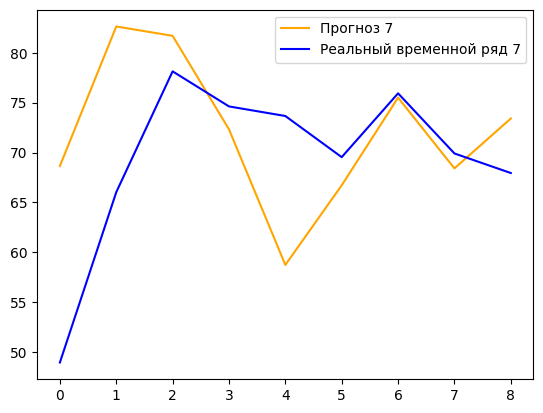

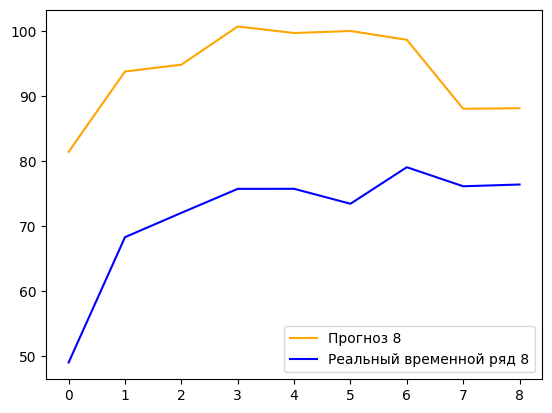

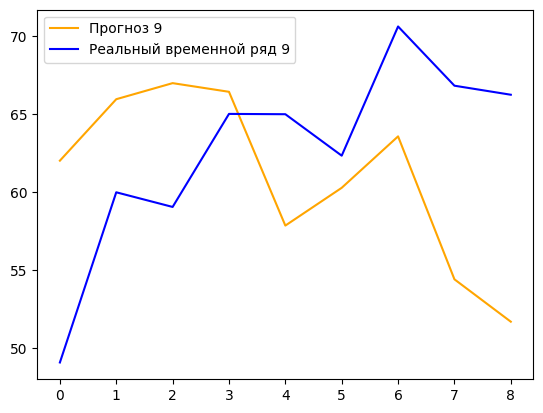

In [239]:
start_point = split_point + 2 * L - 1

for i in range(num_of_series):
    plt.plot(forecasted_ts_x[i], label=f'Прогноз {i}', color='orange')
    plt.plot(df.iloc[start_point:, i].values, label=f"Реальный временной ряд {i}", color='b')
    plt.legend()
    plt.show()

# `Выполнение прогноза при втором способе подсчета Σ`  

In [240]:
forecast_corr_2, actual_corr_2 = forecast(corr_ts_2, n_past, num_of_corr_series_12, split_point)
forecast_corr_2 = forecast_corr_2.set_index(forecast_corr_2.index + split_point + 2 * L - 1)

1/1 [==============================] - 1s 1s/step


In [241]:
for i in range(num_of_corr_series_12):
    ytrue = actual_corr_2.iloc[:, i].values
    yhat = forecast_corr_2.iloc[:, i].values
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    print(f"{i}: MAPE = {mape}, MSE = {mse}")

0: MAPE = 0.17940409862617454, MSE = 80.12933325776835
1: MAPE = 0.23207748225223382, MSE = 118.66460111143182
2: MAPE = 0.47076833152602077, MSE = 302.4360996085914
3: MAPE = 0.4789472282314342, MSE = 395.258474126439
4: MAPE = 0.5072235287936432, MSE = 311.26606398174005
5: MAPE = 0.4929954565364319, MSE = 223.3975401816979
6: MAPE = 4.811543103148943, MSE = 1304.4648991442555
7: MAPE = 0.6790554836247382, MSE = 295.38702121309404
8: MAPE = 0.48795012171498847, MSE = 256.08694727940826
9: MAPE = 0.6316590129202013, MSE = 49.570414251059255
10: MAPE = 0.18604577298115654, MSE = 211.71307616140479
11: MAPE = 0.32784527339269853, MSE = 448.68678410277
12: MAPE = 0.20050912207088023, MSE = 212.19316170049808
13: MAPE = 0.30551467871725196, MSE = 375.49911022620967
14: MAPE = 0.29933810418477313, MSE = 182.5783026863935
15: MAPE = 1.2268852076508254, MSE = 1077.946874538723
16: MAPE = 0.5761563435862737, MSE = 125.09020188026678
17: MAPE = 0.6678354826192545, MSE = 291.89701049076143
18: 

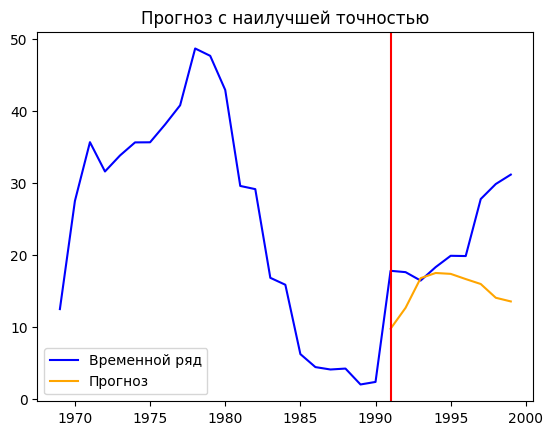

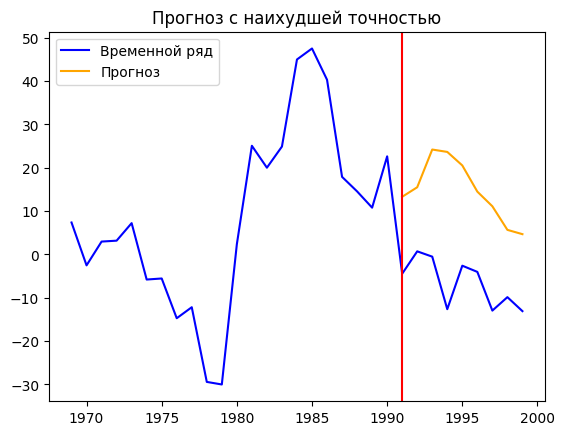

In [242]:
plt.plot(corr_ts_2.iloc[1960:, 54], label="Временной ряд", color='b')
plt.plot(forecast_corr_2.iloc[:, 54], label="Прогноз", color='orange')
plt.axvline(x = split_point + 2 * L - 1, color='r')
plt.title("Прогноз с наилучшей точностью")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[1960:, 32], label="Временной ряд", color='b')
plt.plot(forecast_corr_2.iloc[:, 32], label="Прогноз", color='orange')
plt.axvline(x = split_point + 2 * L - 1, color='r')
plt.title("Прогноз с наихудшей точностью")
plt.legend()
plt.show()

# Восстановление прогноза $\Sigma_2$.

In [243]:
matrix_ts_2 = get_corr_matrices(forecast_corr_2)

In [244]:
from scipy.optimize import Bounds, minimize

def optimized_2(x):
    m = np.zeros((1, num_of_series))
    for k in range(num_of_series): # Вычисляем вектор матожидания
        sum_ = 0
        for l in range(L - 1):
            sum_ += df.iloc[split_point + L + point + l, k] / L
        sum_ += x[k] / L
        m[0, k] = sum_
    sum = 0
    for i in range(L - 1):
        outer = np.outer(df.iloc[split_point + L + point + i, :].values - m, df.iloc[split_point + L + point + i, :].values - m)
        sum += outer / L
    sum += np.outer(x - m, x - m) / L
    return np.linalg.norm(sum - matrix_ts_2[point]) ** 2

def optimize_portfolio_2():
    bnds = Bounds(np.zeros_like(x), np.ones_like(x) * np.inf)

    res = minimize(optimized_2, x, method='SLSQP',
                   bounds=bnds)
    return res.x

In [245]:
forecasted_2 = []

for point in range(optimal_horizon):
    forecasted_2.append(optimize_portfolio_2())

for element in forecasted_2:
    element = list(element)

forecasted_ts_x_2 = []

for i in range(num_of_series):
    forecasted_ts_x_2.append([sublist[i] for sublist in forecasted_2])

AVG_MAPE_x_2 = 0
mape_list_2 = []

for i in range(num_of_series):
    mape_ = MAPE(df.iloc[split_point + 2 * L - 1:, i].values, forecasted_ts_x_2[i])
    mape_list_2.append(mape_)
    print(f'MAPE {i} временного ряда: {mape_}')
    AVG_MAPE_x_2 += mape_

print(f'Средняя ошибка MAPE: {AVG_MAPE_x_2 / num_of_series}')

MAPE 0 временного ряда: 0.20670402601310503
MAPE 1 временного ряда: 0.25086647437908666
MAPE 2 временного ряда: 0.398464501008299
MAPE 3 временного ряда: 0.3576298186234449
MAPE 4 временного ряда: 0.3168065436180887
MAPE 5 временного ряда: 0.24357205748811092
MAPE 6 временного ряда: 0.7735044002139505
MAPE 7 временного ряда: 0.14387332189355184
MAPE 8 временного ряда: 0.1325018241398106
MAPE 9 временного ряда: 0.09448338986780269
Средняя ошибка MAPE: 0.29184063572452507


In [246]:
AVG_MAE_x_2 = 0
mae_list_2 = []
AVG_MSE_x_2 = 0
mse_list_2 = []

for i in range(num_of_series):
    mae_ = MAE(df.iloc[split_point + 2 * L - 1:, i].values, forecasted_ts_x_2[i])
    mse_ = MSE(df.iloc[split_point + 2 * L - 1:, i].values, forecasted_ts_x_2[i])
    mae_list_2.append(mae_)
    mse_list_2.append(mse_)
    print(f'MAE {i} временного ряда: {mae_}, MSE {i} временного ряда: {mse_}')
    AVG_MAE_x_2 += mae_
    AVG_MSE_x_2 += mse_

print(f'Средняя ошибка MAE: {AVG_MAE_x_2 / num_of_series}, MSE: {AVG_MSE_x_2 / num_of_series}')

MAE 0 временного ряда: 12.742868255043094, MSE 0 временного ряда: 194.7437454864655
MAE 1 временного ряда: 13.068455278702091, MSE 1 временного ряда: 252.3100709729124
MAE 2 временного ряда: 17.197287427685726, MSE 2 временного ряда: 377.6677216591988
MAE 3 временного ряда: 13.63819858739776, MSE 3 временного ряда: 246.60029318273624
MAE 4 временного ряда: 10.957565444724954, MSE 4 временного ряда: 168.75308484289323
MAE 5 временного ряда: 8.23591628179877, MSE 5 временного ряда: 92.1978870114323
MAE 6 временного ряда: 21.521024890544783, MSE 6 временного ряда: 608.166626059981
MAE 7 временного ряда: 9.885607727224055, MSE 7 временного ряда: 110.42952277842173
MAE 8 временного ряда: 9.33788257583415, MSE 8 временного ряда: 126.1389899969358
MAE 9 временного ряда: 5.697808968448909, MSE 9 временного ряда: 47.589438673718796
Средняя ошибка MAE: 12.228261543740429, MSE: 222.4597380664696


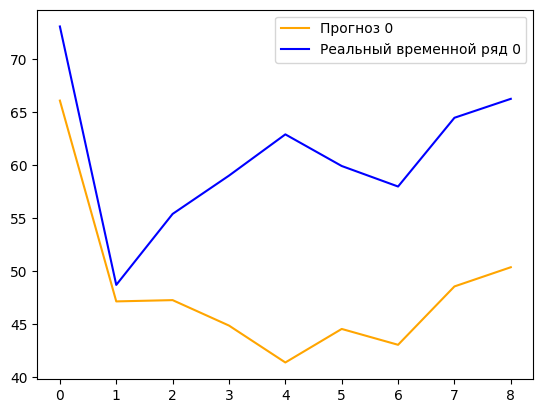

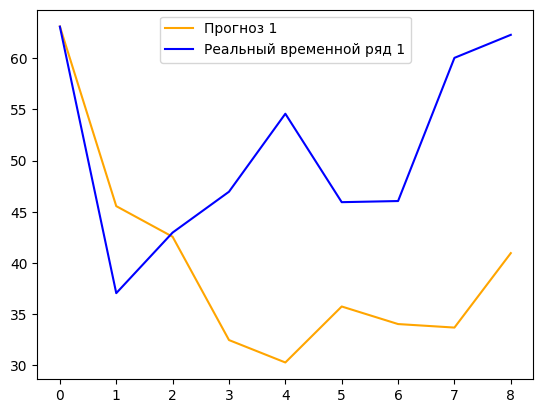

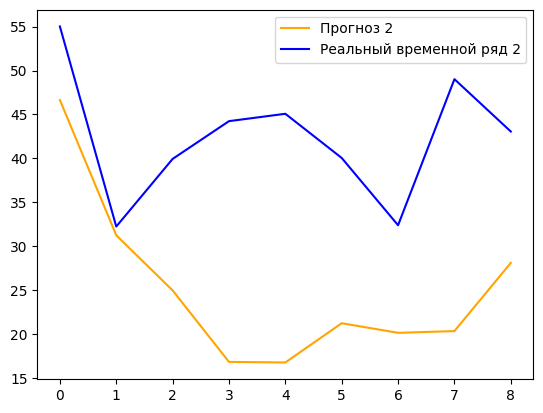

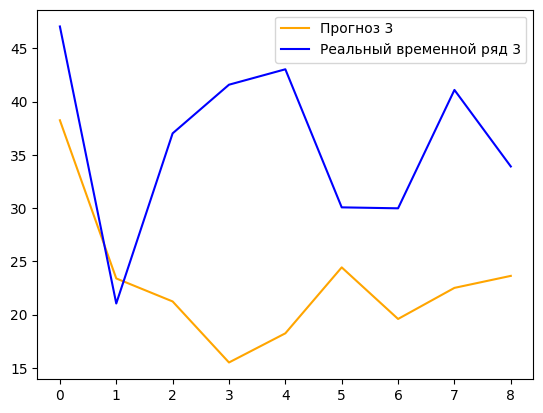

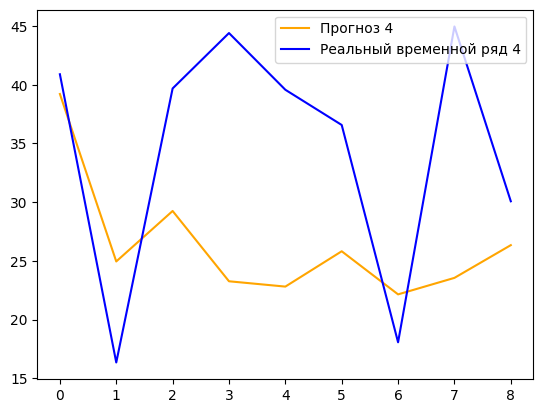

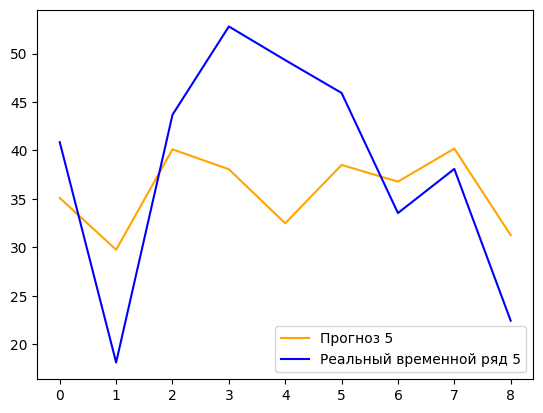

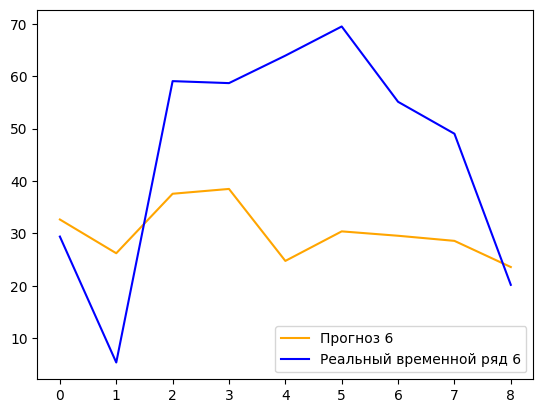

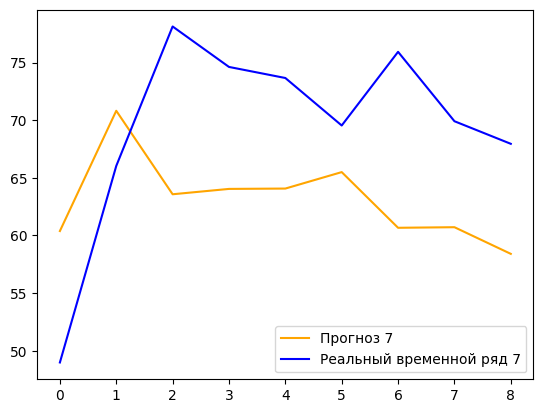

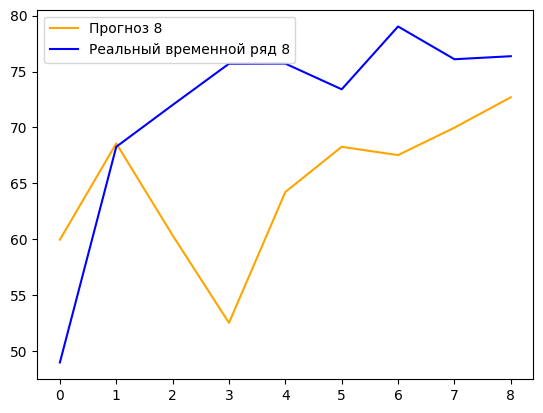

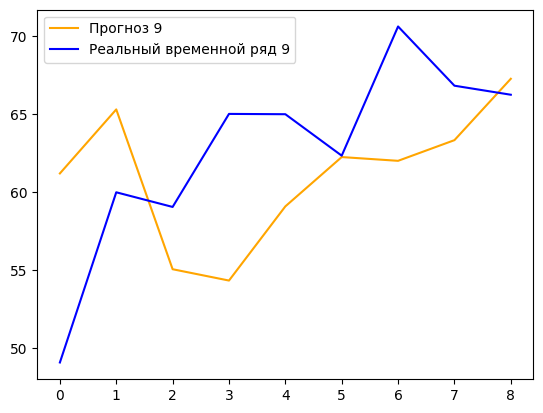

In [247]:
start_point = split_point + 2 * L - 1

for i in range(num_of_series):
    plt.plot(forecasted_ts_x_2[i], label=f'Прогноз {i}', color='orange')
    plt.plot(df.iloc[start_point:, i].values, label=f"Реальный временной ряд {i}", color='b')
    plt.legend()
    plt.show()

# `Выполнение прогноза при третьем способе подсчета ` $\Sigma$.

In [248]:
forecast_corr_3, actual_corr_3 = forecast(corr_ts_3, n_past, num_of_corr_series_3, split_point)
forecast_corr_3 = forecast_corr_3.set_index(forecast_corr_3.index + split_point + 2 * L - 1)

for i in range(num_of_corr_series_3):
    ytrue = actual_corr_3.iloc[:, i].values
    yhat = forecast_corr_3.iloc[:, i].values
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    print(f"{i}: MAPE = {mape}, MSE = {mse}")

1/1 [==============================] - 2s 2s/step
0: MAPE = 0.11779326929522455, MSE = 0.009893263212749434
1: MAPE = 0.10510606895261243, MSE = 0.006501463401704924
2: MAPE = 0.1300388447100515, MSE = 0.00830705910721934
3: MAPE = 0.3285499784900115, MSE = 0.027855631200455786
4: MAPE = 0.3214684163808351, MSE = 0.01680027798577387
5: MAPE = 5.710672165798176, MSE = 0.03776734639269383
6: MAPE = 0.7685012913176641, MSE = 0.10981233976281188
7: MAPE = 0.3978455396120029, MSE = 0.07541472990019414
8: MAPE = 0.7952740636106119, MSE = 0.12990115956766926
9: MAPE = 0.0417131101836537, MSE = 0.001787206647986093
10: MAPE = 0.04450799531422481, MSE = 0.002193633807284697
11: MAPE = 0.10052709635962971, MSE = 0.00725000541624711
12: MAPE = 0.388551268282045, MSE = 0.01672104872327347
13: MAPE = 1.6056822807633229, MSE = 0.0355287305114895
14: MAPE = 1.6734239342556922, MSE = 0.10771302610331973
15: MAPE = 0.9502756520215387, MSE = 0.09050839947961047
16: MAPE = 0.9615701585294898, MSE = 0.149

# Восстановление прогноза $\Sigma_3$

In [249]:
matrix_ts_3 = get_corr_matrices(forecast_corr_3, option=1)

In [250]:
from scipy.optimize import Bounds, minimize

def optimized_3(x):
    m = np.zeros((1, num_of_series))
    for k in range(num_of_series): # Вычисляем вектор матожидания
        sum_ = 0
        for l in range(L - 1):
            sum_ += df.iloc[split_point + L + point + l, k] / L
        sum_ += x[k] / L
        m[0, k] = sum_

    sqrt_dispercion = [] # Заводим массив, где будут храниться корни из дисперсии для каждого момента времени из [i, i + L - 1]
    for k in range(num_of_series): # Рассчитываем вектор корней из дисперсии
        sum_ = 0
        for time in range(L - 1):
            sum_ += ((df.iloc[split_point + L + point + time, k] - m[0, k]) ** 2) / L
        sum_ += ((x[k] - m[0, k]) ** 2) / L

        sqrt_dispercion.append(np.sqrt(sum_))

    sum = 0
    for i in range(L - 1):
        outer = np.outer(df.iloc[split_point + L + point + i, :].values - m, df.iloc[split_point + L + point + i, :].values - m)
        sum += outer / L
    sum += np.outer(x - m, x - m) / L

    for row in range(num_of_series): # Делим [row, col] - ый элемент матрицы на соответствующие корни из дисперсии, получаем матрицу корреляции, т.е Sigma_3
        for col in range(num_of_series):
            sum[row, col] = sum[row, col] / (sqrt_dispercion[row] * sqrt_dispercion[col])

    return np.linalg.norm(sum - matrix_ts_3[point]) ** 2

def optimize_portfolio_3():
    bnds = Bounds(np.zeros_like(x), np.ones_like(x) * np.inf)

    res = minimize(optimized_3, x, method='SLSQP',
                   bounds=bnds)
    return res.x

In [251]:
forecasted_3 = []

for point in range(optimal_horizon):
    forecasted_3.append(optimize_portfolio_3())

for element in forecasted_3:
    element = list(element)

forecasted_ts_x_3 = []

for i in range(num_of_series):
    forecasted_ts_x_3.append([sublist[i] for sublist in forecasted_3])

AVG_MAPE_x_3 = 0
mape_list_3 = []

for i in range(num_of_series):
    mape_ = MAPE(df.iloc[split_point + 2 * L - 1:, i].values, forecasted_ts_x_3[i])
    mape_list_3.append(mape_)
    print(f'MAPE {i} временного ряда: {mape_}')
    AVG_MAPE_x_3 += mape_

print(f'Средняя ошибка MAPE: {AVG_MAPE_x_3 / num_of_series}')

MAPE 0 временного ряда: 0.1610365131531998
MAPE 1 временного ряда: 0.30013641474411706
MAPE 2 временного ряда: 0.4059337794897451
MAPE 3 временного ряда: 0.6996894342322505
MAPE 4 временного ряда: 0.5954824819522432
MAPE 5 временного ряда: 0.4486801067152347
MAPE 6 временного ряда: 0.9002204584423724
MAPE 7 временного ряда: 0.23461188960854804
MAPE 8 временного ряда: 0.20945645107377103
MAPE 9 временного ряда: 0.32530579216465977
Средняя ошибка MAPE: 0.4280553321576141


In [252]:
AVG_MAE_x_3 = 0
mae_list_3 = []
AVG_MSE_x_3 = 0
mse_list_3 = []

for i in range(num_of_series):
    mae_ = MAE(df.iloc[split_point + 2 * L - 1:, i].values, forecasted_ts_x_3[i])
    mse_ = MSE(df.iloc[split_point + 2 * L - 1:, i].values, forecasted_ts_x_3[i])
    mae_list_3.append(mae_)
    mse_list_3.append(mse_)
    print(f'MAE {i} временного ряда: {mae_}, MSE {i} временного ряда: {mse_}')
    AVG_MAE_x_3 += mae_
    AVG_MSE_x_3 += mse_

print(f'Средняя ошибка MAE: {AVG_MAE_x_3 / num_of_series}, MSE: {AVG_MSE_x_3 / num_of_series}')

MAE 0 временного ряда: 10.249706528457112, MSE 0 временного ряда: 140.2193368635109
MAE 1 временного ряда: 16.142490371943243, MSE 1 временного ряда: 341.5921288618589
MAE 2 временного ряда: 17.799503935421043, MSE 2 временного ряда: 395.2356540175317
MAE 3 временного ряда: 26.061756803400087, MSE 3 временного ряда: 856.5538386402467
MAE 4 временного ряда: 20.70325931227702, MSE 4 временного ряда: 548.083739535789
MAE 5 временного ряда: 15.850882069339056, MSE 5 временного ряда: 303.8812691262329
MAE 6 временного ряда: 21.020171942034096, MSE 6 временного ряда: 523.8505125522508
MAE 7 временного ряда: 16.310146805887662, MSE 7 временного ряда: 288.5377850508746
MAE 8 временного ряда: 14.58221942520599, MSE 8 временного ряда: 226.74568069727928
MAE 9 временного ряда: 19.918800548406487, MSE 9 временного ряда: 753.7725419081487
Средняя ошибка MAE: 17.86389377423718, MSE: 437.84724872537237


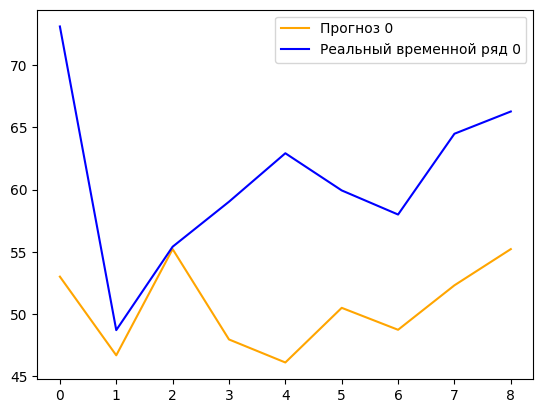

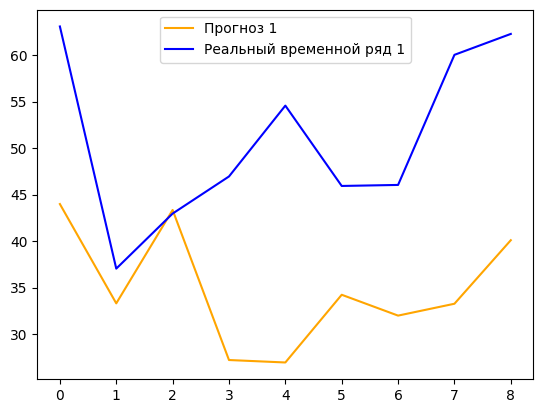

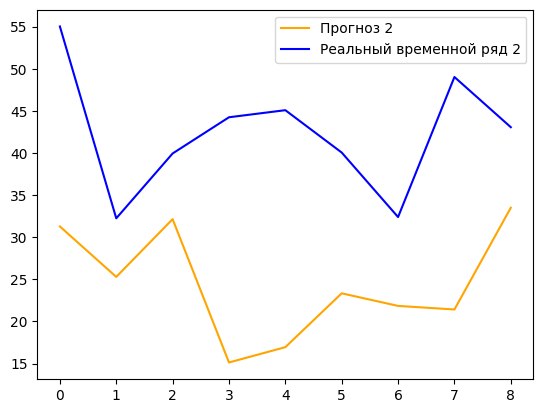

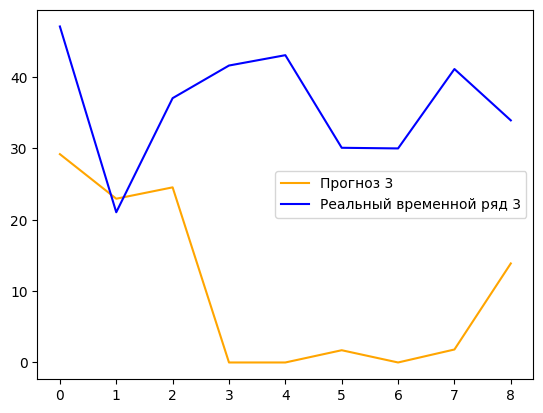

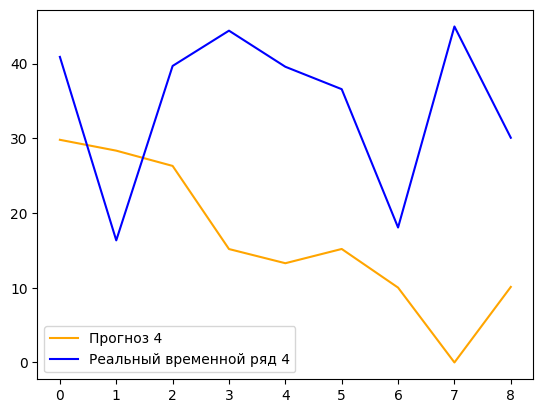

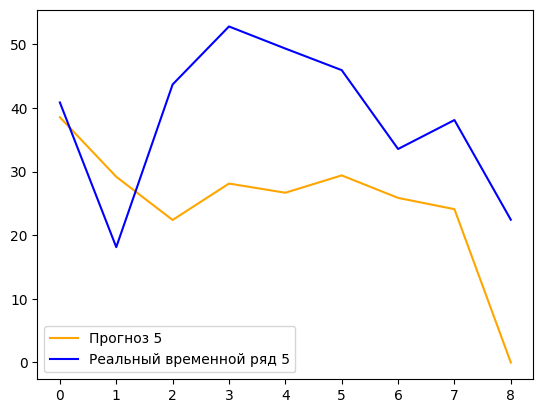

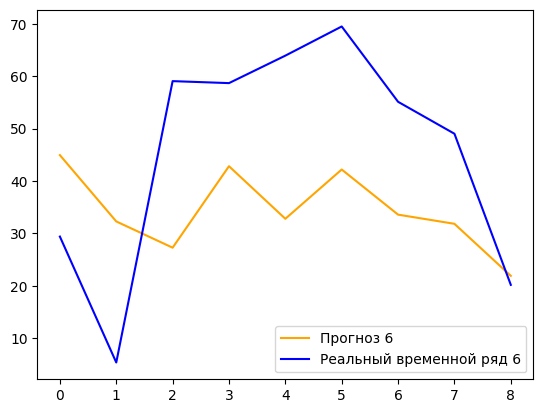

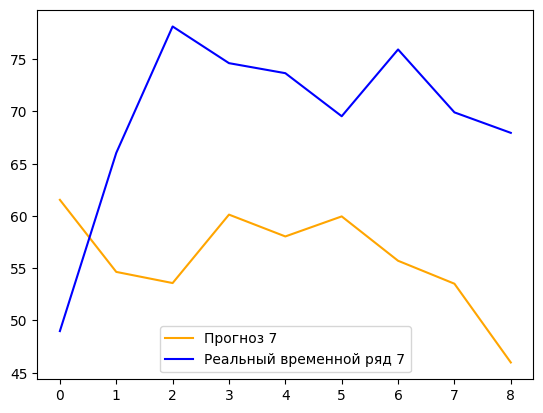

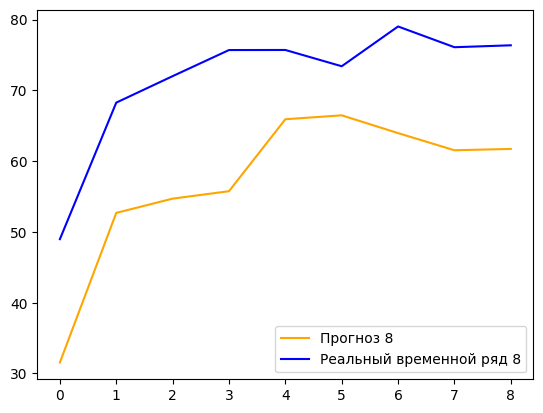

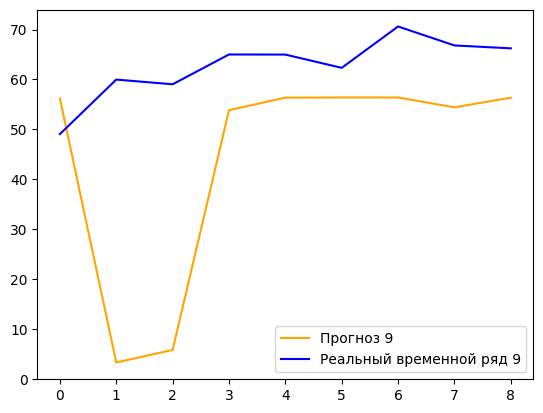

In [253]:
start_point = split_point + 2 * L - 1

for i in range(num_of_series):
    plt.plot(forecasted_ts_x_3[i], label=f'Прогноз {i}', color='orange')
    plt.plot(df.iloc[start_point:, i].values, label=f"Реальный временной ряд {i}", color='b')
    plt.legend()
    plt.show()